**Stock Market Forecasting through Time Series Analysis using Auto-ARIMA Model**

Time Series Analysis:
    - analysis of data points in sequence collected over an interval of time
    - Requirements:
        - Stationary: statistical properties like mean and variance do not change over time
            - non-stationary data require adjustments such as differencing or transformation to achieve stationarity
    - Four Components:
        1. Level: average value in the series
        2. Trend: increasing or falling value in the series
        3. Seasonality: recurring short-term cycle
        4. Noise: random variance in the series

ARIMA: Autoregressive Integrated Moving Average
    - analyzes historical data to forecast short-term movements
    - Three Components:
        1. AR (Autoregressive): models the relationship between a current value and its historical movements
        2. I (Differencing): helps stabilize the series by mitigating variations, making it stationary
        3. MA (Moving Average): manages the noise in the data by smoothing out past forecast errors
    - Auot-ARIMA:
        - Automates differencing by performing differencing tests (e.g., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller, or Phillips–Perron) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled 

**Data Pre-processing**

In [130]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error
import uuid
import math

In [168]:
dataset = pd.read_csv("data/sp500_stocks.csv",
                        sep=',', 
                        index_col='Date', 
                        parse_dates=['Date'], 
                        date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')).dropna()

company_choice = 'MMM'
statistical_column_choice = 'Close'
statistical_column_period = 12
train_data_split = 0.99 # Can't forecast too ahead!
request_id = str(uuid.uuid4())[:8]

dataset = dataset[dataset['Symbol'] == company_choice]
dataset.head()

,Symbol,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,,
2010-01-04,MMM,44.254021,69.414719,69.774246,69.122070,69.473244,3640265.0
2010-01-05,MMM,43.976830,68.979935,69.590302,68.311035,69.230766,3405012.0
2010-01-06,MMM,44.600502,69.958191,70.735786,69.824417,70.133781,6301126.0
2010-01-07,MMM,44.632473,70.008362,70.033447,68.662209,69.665550,5346240.0
2010-01-08,MMM,44.946968,70.501671,70.501671,69.648827,69.974915,4073337.0


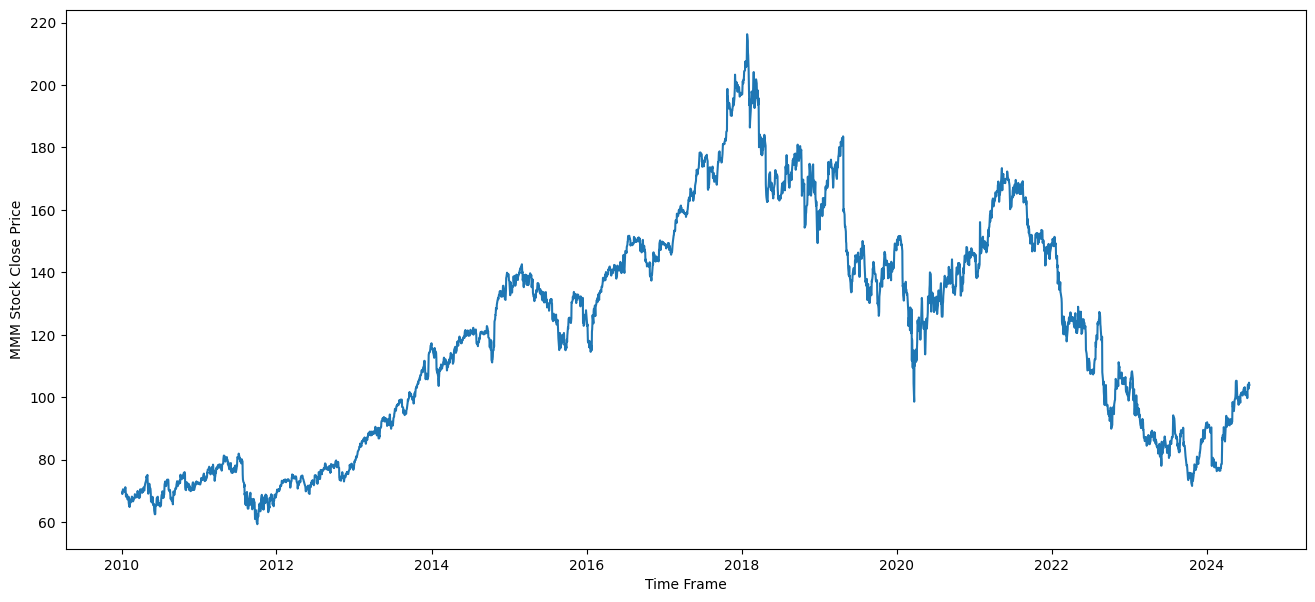

In [169]:
# Data Exploration
dataset.describe()

# Plot statistical_column_choice price
plt.figure(figsize=(16,7))
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time Frame')
ax1.set_ylabel(company_choice + ' Stock ' + statistical_column_choice + ' Price')
ax1.plot(dataset[statistical_column_choice])
plt.savefig('tmp/value_plot_' + request_id + '.png')

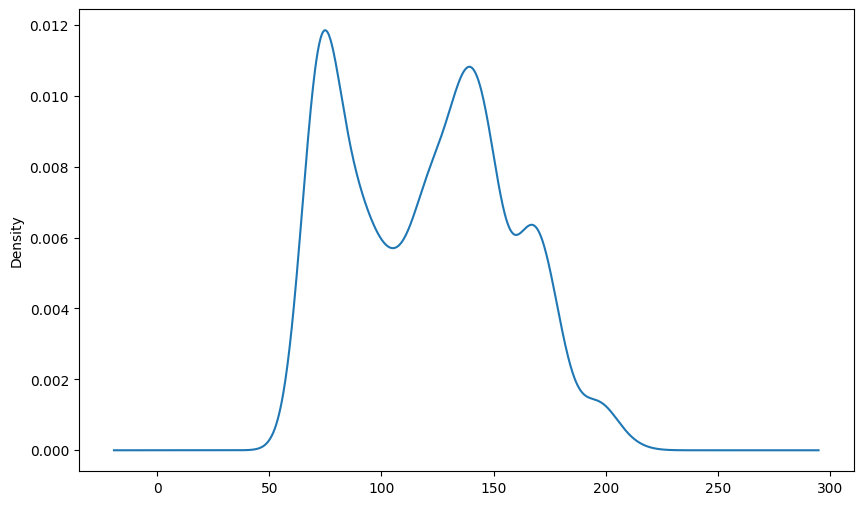

In [170]:
# Plot probability distribution of dataset

# Probability Distribution: describes the likelihood of a variable taking each value it can possibly take
# Kernel Density Estimation (KDE) is a non-parametric way to estimate the probability density function of a random variable. 
# KDE is used to create a smooth curve representing the distribution of data points in a dataset.
dataset[statistical_column_choice].plot(kind='kde')
plt.savefig('tmp/kde_plot_' + request_id + '.png')

**Tests for Stationarity**
1. Augmented Dickey-Fuller(ADF) Test:
    - determines whether or not a series has a unit root
    - Null Hypothesis: The series has a unit root (value of a=1) -> non-stationary
    - Alternate Hypothesis: The series has no unit root -> stationary
    - Output:
        - Test Statistics: a lower (more negative) test statistic value indicates stronger evidence against the null hypothesis
        - p-value: indicates the probability of obtaining a test statistic at least as extreme as the one observed, under the assumption that the null hypothesis is true
            - A high p-value (typically greater than 0.05) suggests that we cannot reject the null hypothesis
        - critical-values: If the test statistic is less than (more negative than) these critical values, we can reject the null hypothesis at the corresponding significance level

    - Interpretation Example:
        Given the results:
            Test Statistic: 1.085056
            p-value: 0.995087
            Critical Values:
            1% level: -3.432148
            5% level: -2.862334
            10% level: -2.567193
        
        Inference: The test statistic (1.085056) is higher than all the critical values (-3.432148, -2.862334, -2.567193). Additionally, the p-value (0.995087) is much greater than the typical threshold of 0.05

        Conclusion:
            - The test does not reject the null hypothesis i.e. data is non-stationary

2. Rolling Statistics
    - Interpretation: If the rolling mean and standard deviation are roughly constant, the series is likely to be stationary

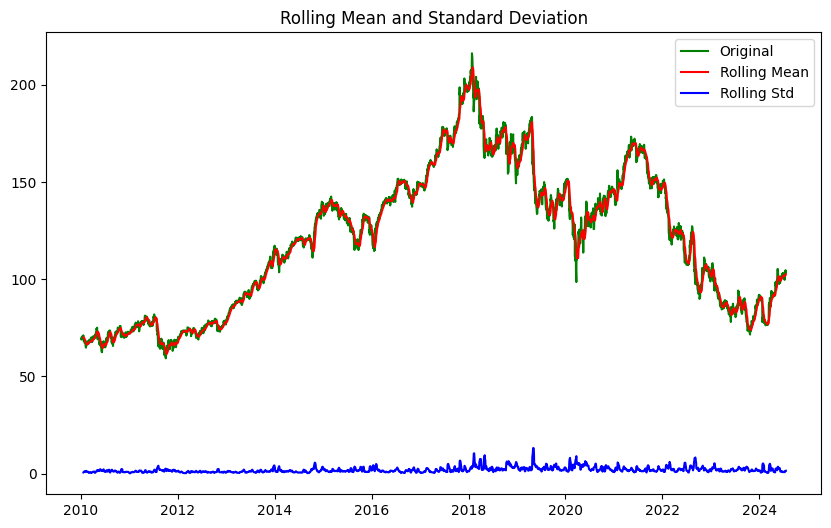

Results of Augmented Dickey-Fuller(ADF) Test:
Test Statistics                  -1.715810
p-value                           0.422986
No. of lags used                  9.000000
Number of observations used    3650.000000
critical value (1%)              -3.432143
critical value (5%)              -2.862332
critical value (10%)             -2.567192
dtype: float64


<Figure size 1000x600 with 0 Axes>

In [171]:
#Test for staionarity
def test_stationarity(timeseries):
    # Calculate moving average for mean and std over a window of 12 periods
    rolmean = timeseries.rolling(statistical_column_period).mean()
    rolstd = timeseries.rolling(statistical_column_period).std()

    #Plot rolling statistics
    plt.plot(timeseries, color='green',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='blue', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    plt.savefig('tmp/rolling_statistics_' + request_id + '.png')


    print("Results of Augmented Dickey-Fuller(ADF) Test:")
    adft = adfuller(timeseries,autolag='AIC')
    # Add index to o/p columns
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(dataset[statistical_column_choice])

**Eliminate Trend and Seaonality**

<Figure size 1000x600 with 0 Axes>

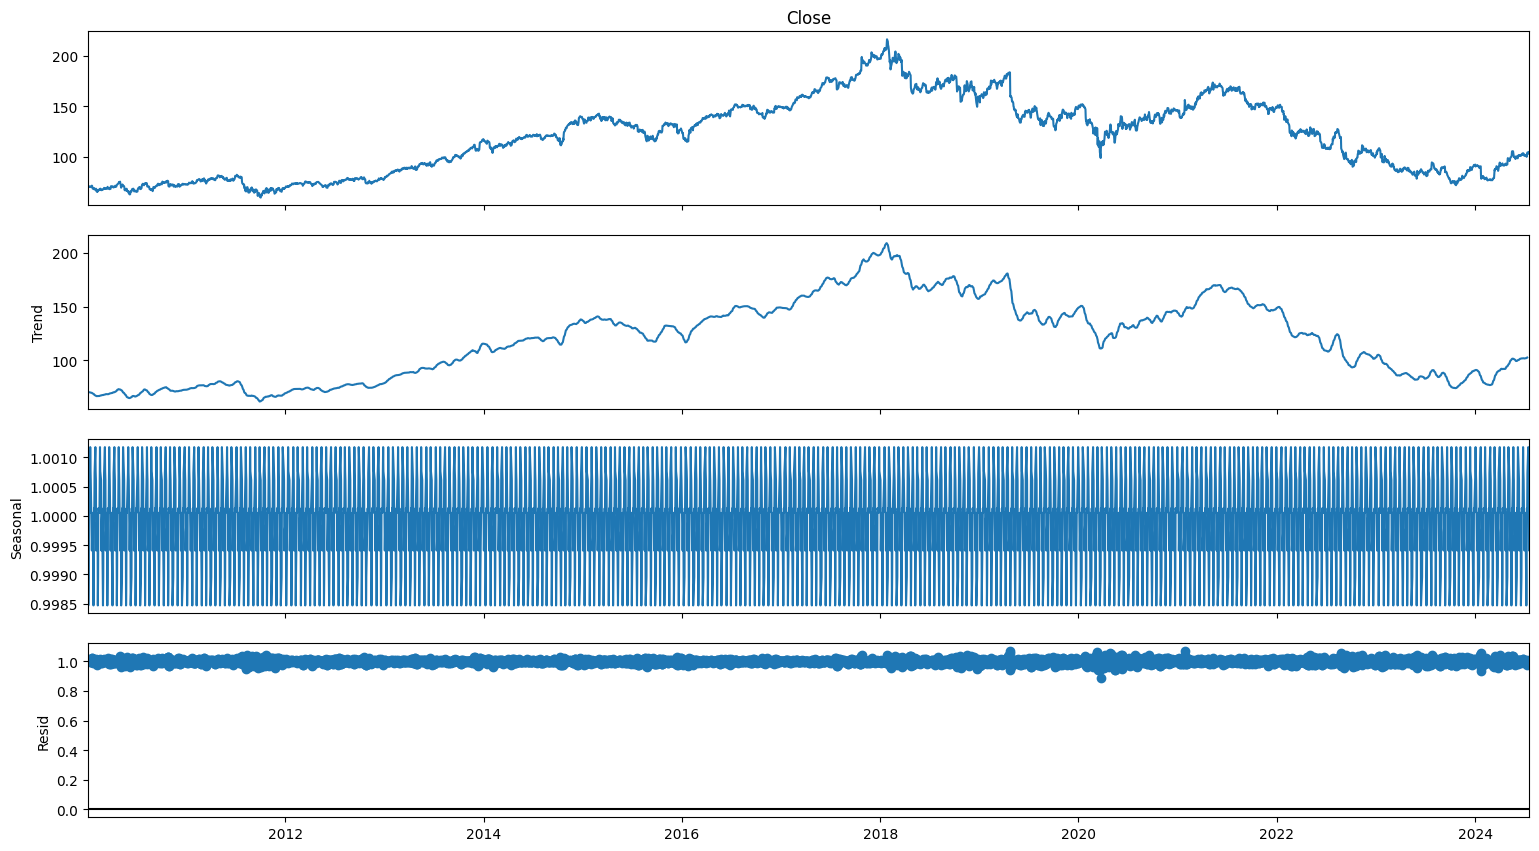

In [172]:
seasonal_decompose_output = seasonal_decompose(dataset[statistical_column_choice], model='multiplicative', period=statistical_column_period)
fig = plt.figure()  
fig = seasonal_decompose_output.plot()  
fig.set_size_inches(16, 9)
fig.savefig('tmp/seasonal_decompose_' + request_id + '.png')

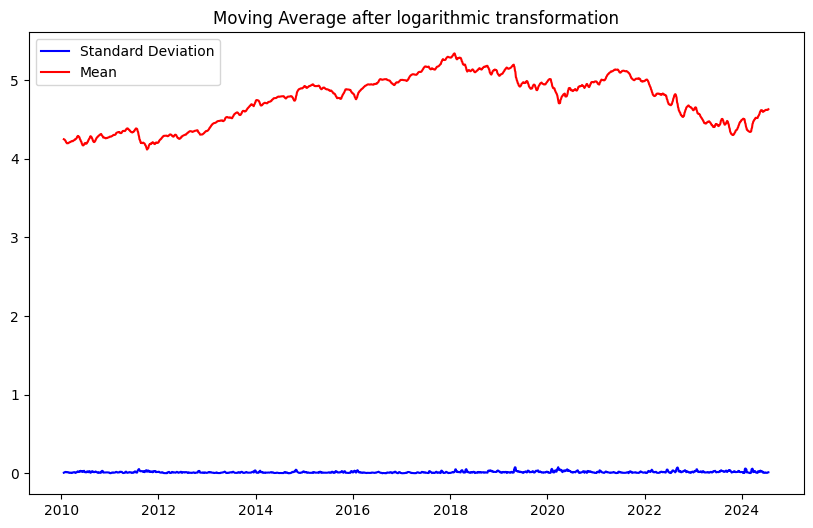

In [173]:
rcParams['figure.figsize'] = 10, 6
# Apply logarithmic transformation to stabilize variance and make the data more stationary
dataset_log = np.log(dataset[statistical_column_choice])
moving_avg = dataset_log.rolling(statistical_column_period).mean()
std_dev = dataset_log.rolling(statistical_column_period).std()

plt.legend(loc='best')
plt.title('Moving Average after logarithmic transformation')
plt.plot(std_dev, color ="blue", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()
fig.savefig('tmp/log_transformed_moving_avg_' + request_id + '.png')

**Training the model**

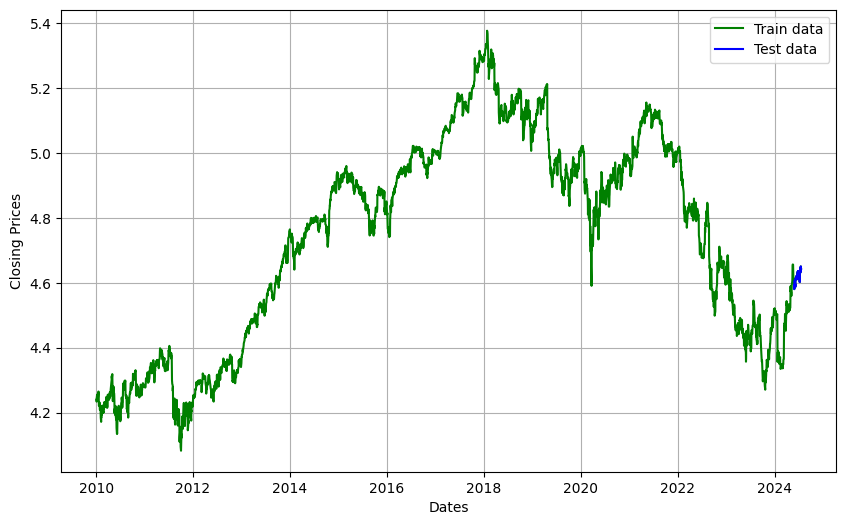

In [174]:
# Split data into train and training set
train_data, test_data = dataset_log[1:int(len(dataset_log)*train_data_split)], dataset_log[int(len(dataset_log)*train_data_split):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(dataset_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
fig.savefig('tmp/train_test_split_' + request_id + '.png')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-20460.104, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-20463.416, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-20463.617, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-20461.922, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-20463.774, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-20459.990, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-20461.137, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-20462.853, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-20462.654, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-20457.951, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-20465.560, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-20465.421, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-20465.220, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-20461.819, Time=0.09 sec
 ARIM

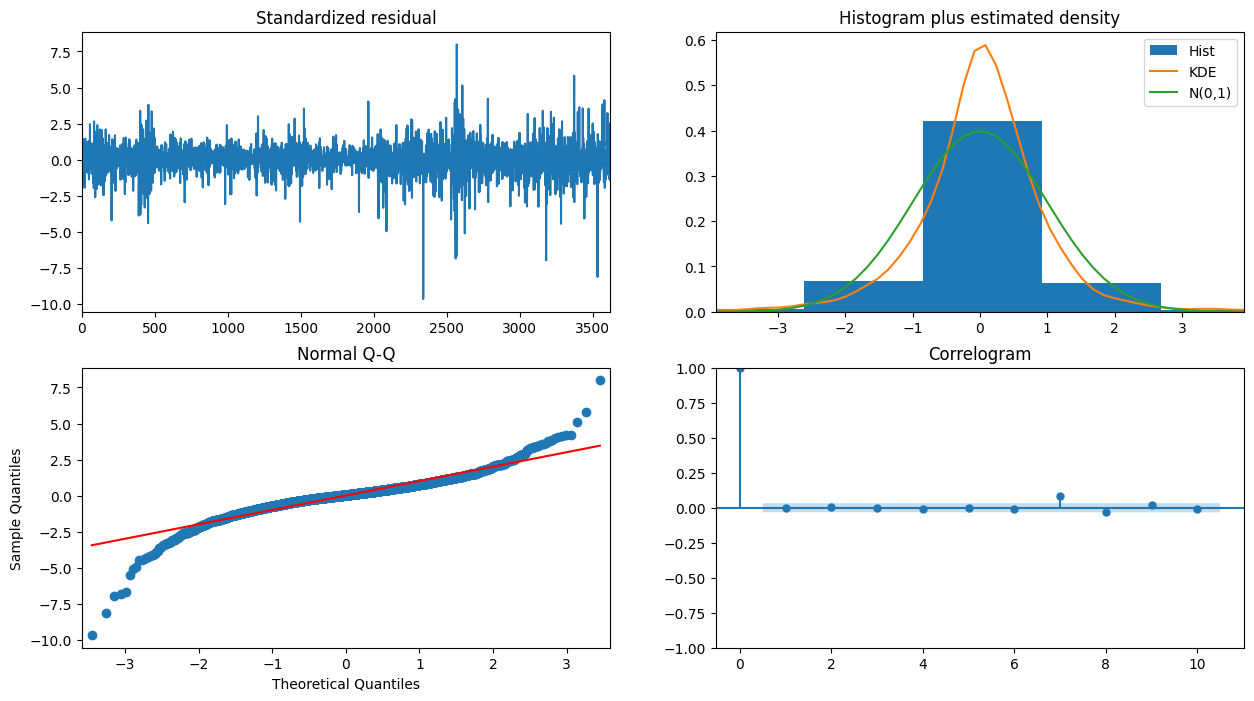

In [175]:
# Find optimal hyper-parameters (p, q, d) using auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
fig.savefig('tmp/arima_fitted_params_' + request_id + '.png')

In [176]:
# Train the model
# AR(p): AutoRegressive part with 1 lag. 
# I(d): Integrated part with 1 differencing.
# MA(q): Moving Average part with 2 lags.
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3622
Model:                 ARIMA(1, 1, 2)   Log Likelihood               10235.397
Date:                Sun, 21 Jul 2024   AIC                         -20462.795
Time:                        10:39:05   BIC                         -20438.017
Sample:                             0   HQIC                        -20453.967
                               - 3622                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6948      0.242      2.869      0.004       0.220       1.169
ma.L1         -0.7343      0.241     -3.050      0.002      -1.206      -0.263
ma.L2          0.0092      0.018      0.501      0.6

**Forecasting**

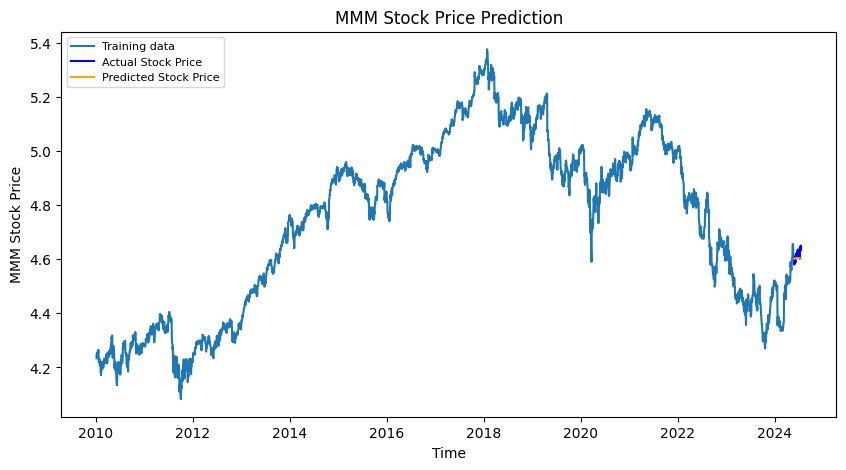

In [179]:
# Forecast
fc = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
forecast_series = pd.Series(fc)
forecast_dates = test_data.index

# Set the index of forecast_series to these dates
forecast_series.index = forecast_dates

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(forecast_series, color = 'orange',label='Predicted Stock Price')
plt.title(company_choice + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(company_choice + ' Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [178]:
# Report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.0004959195560689221
MAE: 0.01896549695237123
RMSE: 0.02226925135851949
MAPE: 0.004099944028165441
